A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset

In [4]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [5]:
filterwarnings('ignore', 'findfont')

In [6]:
blue, green, red, purple, gold, teal = sns.color_palette()

pct_formatter = StrMethodFormatter('{x:.1%}')

In [7]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# Open Source Bayesian Inference in Python with PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>


## FOSSCON &#8226; Philadelphia &#8226; August 26, 2017

## [@AustinRochford](https://twitter.com/AustinRochford)

## Who am I?

<center><img src='http://austinrochford.com/resources/img/face_big.png' width=400></center>

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [GitHub](https://github.com/AustinRochford/) &#8226; [Website](austinrochford.com)

### [austin.rochford@gmail.com](mailto:austin.rochford@gmail.com) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)

### PyMC3 developer &#8226; Principal Data Scientist at [Monetate Labs](http://www.monetate.com/)

## Bayesian Inference

A motivating question:

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

### Conditional Probability

[_Conditional probability_](https://en.wikipedia.org/wiki/Conditional_probability) is the probability that one event will happen, given that another event has occured.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{the probability that } A \textrm{ will happen if we know that } B \textrm{ has happened} \\
    & = \frac{P(A \textrm{ and } B)}{P(B)}.
\end{align*}
$$

Our question,

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

becomes

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Bayes' Theorem

[Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) shows how to get from $P(B\ |\ A)$ to $P(A\ |\ B)$.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg' width=400></center>

Bayes' Theorem follows directly from the definition of conditional probability.

$$
\begin{align*}
P(A\ |\ B) P(B)
    & = P(A \textrm{ and } B) \\
    & = P(B \textrm{ and } A) \\
    & = P(B\ |\ A) P(A).
\end{align*}
$$

Dividing by $P(B)$ yields Bayes' theorem.  Each component of Bayes' Theorem has a name. The <font color="red">posterior distribution</font> is equal to the <font color="blue">joint distribution</font> divided by the <font color="green">marginal distribution of the evidence</font>.

$$\color{red}{P(A\ |\ B)} = \frac{\color{blue}{P(B\ |\ A)\ P(A)}}{\color{green}{P(B)}}.$$

For many useful models the <font color="green">marginal distribution of the evidence</font> is **hard or impossible to calculate analytically**.

The first step below follows from Bayes' theorem, the second step follows from the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability).

$$
\begin{align*}
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +)} \\
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)}
\end{align*}
$$

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)} \\
        & = \frac{0.999 \times 10^{-5}}{0.999 \times 10^{-5} + 0.001 \times \left(1 - 10^{-5}\right)}
\end{align*}
$$

Strikingly, a person that tests positive has a less than 1% chance of actually having the disease!  (Worryingly, only 21% of doctors answered this question correctly in a [recent study](https://blogs.cornell.edu/info2040/2014/11/12/doctors-dont-know-bayes-theorem/).)

In [8]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

## Probabilistic Programming for Bayesian Inference

<center><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png"></center>

This calculation was tedious to do by hand, and only had a closed form answer because of the simplicity of this situation.

<center><a href="https://automatetheboringstuff.com/"><img src="https://automatetheboringstuff.com/images/automate_cover_medium.png"></a></center>

We know the disease is present in one in one hundred thousand people.

The [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) gives the probability that a weighted coin flip comes up heads.  If $X \sim \textrm{Bernoulli}(p),$

$$
\begin{align*}
P(X = 1)
    & = p \\
P(X = 0)
    & = 1 - p.
\end{align*}
$$

In [9]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('has_disease', 1e-5)

If a person has the disease, there is a 99.9% chance they test positive.  If they do not have the disease, there is a 0.1% chance they test positive.

In [10]:
with disease_model:
    p_test_pos = has_disease * 0.999 + (1 - has_disease) * 0.001

This person has tested positive for the disease.

In [11]:
with disease_model:
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

What is the probability that this person has the disease?

In [12]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED)

Assigned BinaryGibbsMetropolis to has_disease
100%|██████████| 10500/10500 [00:02<00:00, 3778.15it/s]


The `disease_trace` object contains samples from the posterior distribution of `has_disease`, given that we have observed a positive test.

In [13]:
disease_trace['has_disease']

array([0, 0, 0, ..., 0, 0, 0])

The mean of the posterior samples of `has_disease` is the posterior probability that the person has the disease, given that they tested positive.

In [14]:
disease_trace['has_disease'].mean()

0.0104

In [15]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

### Monte Carlo Methods

[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) use random sampling to approximate quantities that are difficult or impossible to calculate analytically.  They are used extensively in Bayesian inference, where the marginal distribution of the evidence is usually impossible to calculate analytically for interesting models.

First we generate 5,000 points randomly distributed in a square of area one.

In [16]:
N = 5000

x, y = np.random.uniform(0, 1, size=(2, N))

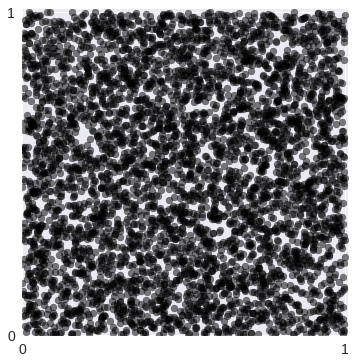

In [17]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

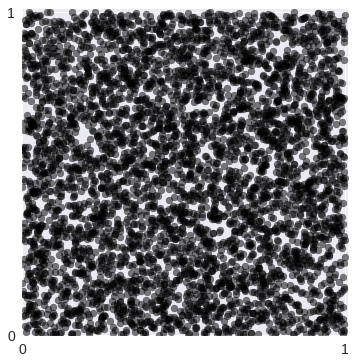

In [18]:
fig

By counting the number of these points that fall inside the quarter circle of radius one, we get an approximation of the area of this quarter circle, which is $\frac{\pi}{4}$.

In [19]:
in_circle = x**2 + y**2 <= 1

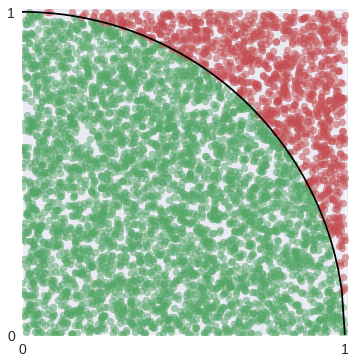

In [20]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c=green, alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c=red, alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

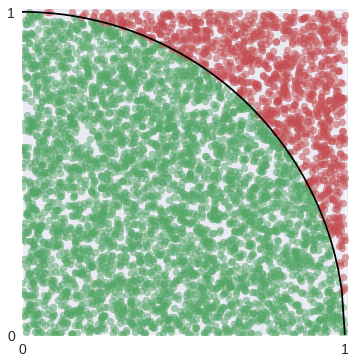

In [21]:
fig

Sure enough, four times the approximation of the quarter circle's area is quite close to $\pi$.  More points would lead to a better approximation.

In [22]:
4 * in_circle.mean()

3.1272000000000002

#### History of Monte Carlo Methods

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

Monte Carlo methods were used extensively in the [Manhattan Project](https://en.wikipedia.org/wiki/Monte_Carlo_method#Definitions).  Pictured aboe are Manhattan Project scientists [Stanislaw_Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), [Richard Feynman](https://en.wikipedia.org/wiki/Richard_Feynman), and [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann).  While working on the Manhattan Project, Ulam gave one of the first descriptions of [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithms.  The [Stan](http://mc-stan.org/) probabilistic programming package is named in his honor.

## The Monty Hall Problem

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

The [Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) is a famous probability puzzle, based on the 1960s game show [Let's Make a Deal](https://en.wikipedia.org/wiki/Let%27s_Make_a_Deal) and named after its original host.  In the show, a contestant would be presented with three unmarked doors, two of which contained an item of little to no value (for example, a goat) and one of which contained a very valuable item (for example, a sportscar).  The contestant would make an initial guess of which door contained the sportscar.  After the contestant's intial guess, Monty would open on of the other two doors, revealing a goat.  Monty would then offer the contestant the chance to change their choice of door.  The Monty Hall problem asks, should the contestant keep their initial hoice of door, or change it?

Initially, we have no information about which door the prize is behind.

In [23]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

If we choose door one:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [24]:
from theano import tensor as tt

with monty_model:
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty opened the third door, revealing a goat.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [25]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Should we switch our choice of door?

In [26]:
with monty_model:
    monty_trace = pm.sample(draws=10000, random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Assigned Metropolis to prize
100%|██████████| 10500/10500 [00:01<00:00, 6014.74it/s]


In [27]:
monty_df.prize.head()

0    0
1    0
2    0
3    0
4    1
Name: prize, dtype: int64

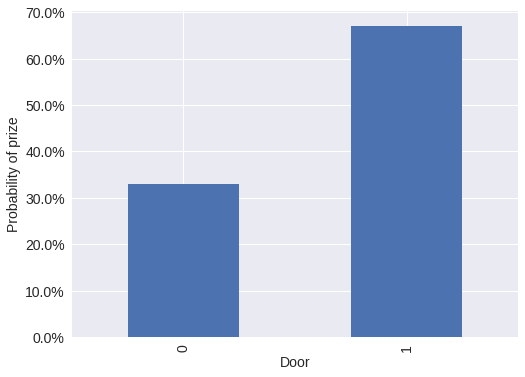

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar', ax=ax))

ax.set_xlabel("Door");
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability of prize");

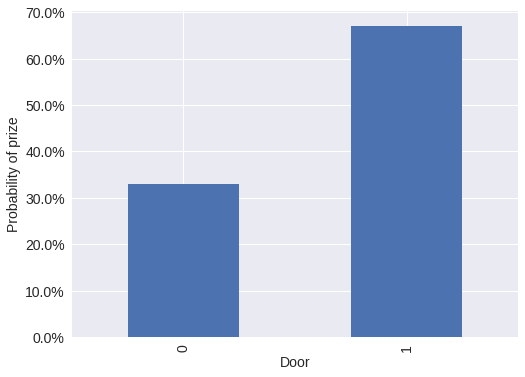

In [29]:
fig

Yes, we should switch our choice of door.

**Optional**

We can also resolve the Monty Hall problem with pen and paper, as follows.

Throughout this calculation, all probabilities assume that we have initially chosen the first door.  By Bayes' Theorem, the probability that the sportscar is behind door one given that Monty opened door three is

$$P(\textrm{Behind door one}\ |\ \textrm{Opened door three}) = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})}.$$

The a priori probability that the prize is behind any of the doors is one third.  From the table above, $P(\textrm{Opened door three}\ |\ \textrm{Behind door one}) = \frac{1}{2}$.  We calculate $P(\textrm{Opened door three})$ using the law of total probability as follows:

$$
\begin{align*}
P(\textrm{Opened door three})
    & = P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door two})P(\textrm{Behind door two}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door three})P(\textrm{Behind door three}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3} \\
    & = \frac{1}{2}.
\end{align*}
$$

Therefore

$$
\begin{align*}
P(\textrm{Behind door one}\ |\ \textrm{Opened door three})
    & = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})} \\
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{3}} \\
    & = \frac{1}{3}.
\end{align*}$$

Since $P(\textrm{Behind door three}\ |\ \textrm{Opened door three}) = 0$, because Monty wants the contestant's choice to be suspensful, $P(\textrm{Behind door two}\ |\ \textrm{Opened door three}) = \frac{2}{3}$.  Therefore it is correct to switch doors, confirming our computational results.

## Introduction to PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

From the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/):

> PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems.

[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

<center><img src="https://numfocus.wpengine.com/wp-content/uploads/2017/03/1457562110.png"></center>

As of October 2016, PyMC3 is a [NumFOCUS fiscally sponsored project](https://www.numfocus.org/blog/numfocus-announces-new-fiscally-sponsored-project-pymc3/).

### Features

* Uses [Theano](http://deeplearning.net/software/theano/) as a computational backend
    * Automated differentiation, dynamic C compilation, GPU integration
* Implements Hamiltonian Monte Carlo and [No-U-Turn sampling](https://arxiv.org/abs/1111.4246)
* High-level GLM (`R`-like syntax) and Gaussian process specification
* General framework for [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)

If you are interested in starting to contribute, we maintain a list of beginner friendly issues on GitHub that require minimal knowledge of the existing codebase to resolve.  We also have an active Discourse forum for discussion PyMC3 development and usage, and a somewhat less active Gitter chat.

### Contributing

<center><a href="https://github.com/pymc-devs/pymc3/issues?q=is%3Aissue+is%3Aopen+label%3Abeginner_friendly"><img src="http://austinrochford.com/resources/talks/img/beginner_friendly.png" width="700"></a></center>

<center><a href="https://discourse.pymc.io/">Discourse</a></center>
<center><a href="https://gitter.im/pymc-devs/pymc?utm_source=badge&utm_medium=badge&utm_campaign=pr-badge&utm_content=badge"><img src="https://badges.gitter.im/gitterHQ/gitter.png"></a></center>

We're also a friendly group of software engineers, statisticians, and data scientists spread across North America and Europe.

<center><img src="https://pbs.twimg.com/media/C_FgWkLV0AAYDBO.jpg" width="700"></center>

## Case Study: Sleep Deprivation

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg/1280px-%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg" width=300></center>

The data for this example are from the [`lme4`](https://cran.r-project.org/web/packages/lme4/) R package, which got them from

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen C. Sing, Daniel P. Redmond, Michael B. Russo and Thomas J. Balkin (2003) Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: a sleep dose-response study. _Journal of Sleep Research_ 12, 1–12.

In [30]:
sleep_df = (get_rdataset('sleepstudy', 'lme4', cache=True)
                .data
                .rename(columns=str.lower)
                .assign(reaction_std=lambda df: (df.reaction - df.reaction.mean()) / df.reaction.std()))

In [31]:
sleep_df.head()

,reaction,days,subject,reaction_std
0,249.5600,0,308,-0.868968
1,258.7047,1,308,-0.706623
2,250.8006,2,308,-0.846944
3,321.4398,3,308,0.407108
4,356.8519,4,308,1.035777


In this study, each subject got their normal amount of sleep.  They were reduced to three hours of sleep each subsequent day.  The `reaction` column is their average response time on a number of tests.  The `reaction_std` column is the result of [standardizing](https://en.wikipedia.org/wiki/Standard_score) `reaction` across all subjects and days.

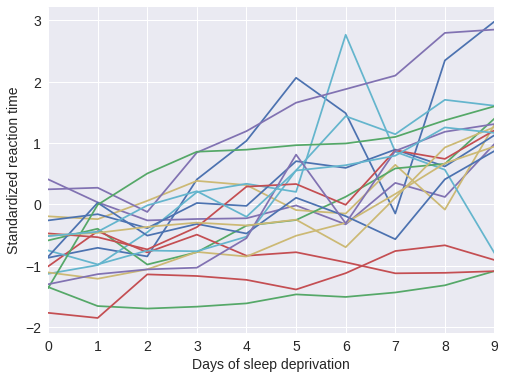

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

(sleep_df.groupby('subject')
         .plot('days', 'reaction_std',
               ax=ax, legend=False));

ax.set_xlabel("Days of sleep deprivation");
ax.set_ylabel("Standardized reaction time");

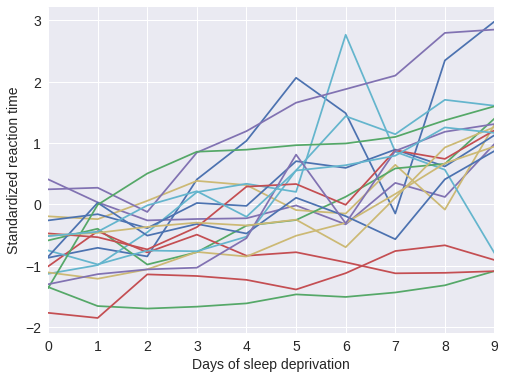

In [33]:
fig

We translate the subject ids in `sleep_df`, which start at 308, to begin at zero and increase sequentially.

In [34]:
subject_ix, subject_map = sleep_df.subject.factorize()
n_subjects = subject_map.size

days = sleep_df.days.values
reaction_std = sleep_df.reaction_std.values

Each subject has a baseline reaction time, which should not be too far apart.

In [35]:
with pm.Model() as sleep_model:
    μ_α = pm.Normal('μ_α', 0., 5.)
    σ_α = pm.HalfCauchy('σ_α', 5.)
    α = pm.Normal('α', μ_α, σ_α, shape=n_subjects)

Each subject's reaction time increases at a different rate after days of sleep deprivation.

In [36]:
with sleep_model:
    μ_β = pm.Normal('μ_β', 0., 5.)
    σ_β = pm.HalfCauchy('σ_β', 5.)
    β = pm.Normal('β', μ_β, σ_β, shape=n_subjects)

The baseline reaction time and rate of increase lead to the observed reaction times.

In [37]:
with sleep_model:
    μ = pm.Deterministic('μ', α[subject_ix] + β[subject_ix] * days)
    σ = pm.HalfCauchy('σ', 5.)
    obs = pm.Normal('obs', μ, σ, observed=reaction_std)

This type of model is known as a hierarchical (or mixed) linear model, because we allow the slope and intercept to vary by subject, but add a regularizing prior shared across subjects.  To learn more about this type of model, consuly Gelman and Hill's [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/).

In [38]:
N_JOBS = 3
JOB_SEEDS = [SEED + i for i in range(N_JOBS)]

with sleep_model:
    sleep_trace = pm.sample(njobs=N_JOBS, random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:08<00:00, 204.48it/s]


### Convergence Diagnostics

PyMC3 provides a number of [statistcal convergence diagnostics](http://pymc-devs.github.io/pymc3/api/stats.html) to help ensure that the samples are a good approximation to the true posterior distribution.

Energy plots and the Bayesian fraction of missing information (BFMI) are two diagnostics relevant to Hamiltonian Monte Carlo sampling, which we have used in this example.  If the two distributions in the energy plot differ significantly (espescially in the tails), the sampling was not very efficient.  The Bayesian fraction of missing information quantifies this difference with a number between zero and one.  A BFMI close to one is preferable, and a BFMI lower than 0.2 is indicative of efficiency issues.

For more information on energy plots and BFMI consult Michael Betancourt's [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) and [_Robust Statistical Workflow with PyStan_](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

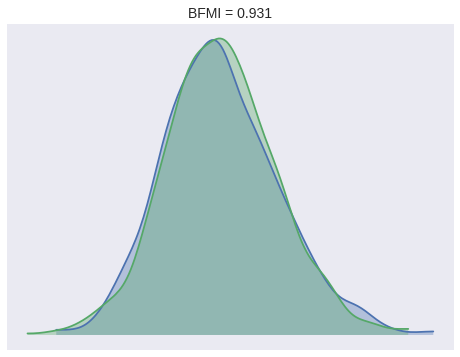

In [39]:
ax = pm.energyplot(sleep_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(sleep_trace)));

In contract to energy plots and BFMI, which are specific to Hamiltonian Monte Carlo algorithms, [Gelman-Rubin](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) statistics are applicable to any MCMC algorithm, as long as multiple chains are available.  Gelman-Rubin statistics near one are preferable, and values less than 1.1 are generally taken to indicate convergence.

In [40]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(sleep_trace).values())

1.0019478091296214

### Prediction

In the Bayesian framework, prediction is done by sampling from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), which is the distribution of possible future observations, given the current observations.

In [41]:
with sleep_model:
    pp_sleep_trace = pm.sample_ppc(sleep_trace)

100%|██████████| 500/500 [00:00<00:00, 1229.55it/s]


We convert the posterior predictive samples to a `DataFrame`.

In [42]:
PP_DATA= {'pp_{}'.format(i):  pp_col for i, pp_col in enumerate(pp_sleep_trace['obs'])}
PP_COLS = list(PP_DATA.keys())

pp_df = sleep_df.assign(**PP_DATA)

In [43]:
pp_df.head()

,reaction,days,subject,reaction_std,pp_0,pp_1,pp_10,pp_100,pp_101,pp_102,...,pp_90,pp_91,pp_92,pp_93,pp_94,pp_95,pp_96,pp_97,pp_98,pp_99
0,249.5600,0,308,-0.868968,-1.291960,-0.589335,-0.486667,-0.113673,-0.883384,-0.986642,...,0.020943,-1.326949,-1.500569,-0.714939,-0.317013,-0.324610,-1.503034,-0.628415,-0.965806,-1.725439
1,258.7047,1,308,-0.706623,-1.042239,-0.870131,-0.813226,0.014996,-0.280247,-1.363919,...,0.211905,-0.763726,-0.486138,-0.295449,-0.897369,-0.572406,0.008697,-0.098248,-0.712696,-0.916789
2,250.8006,2,308,-0.846944,-0.268054,-0.094989,-0.151974,-0.183054,-0.204408,-0.675364,...,0.327711,0.415047,-0.020172,0.452981,0.216747,-1.200510,-0.021161,-0.712794,0.589043,-0.156308
3,321.4398,3,308,0.407108,0.516326,-0.149913,-0.179693,0.295241,-0.069714,0.139928,...,0.713510,0.912917,1.018288,1.140916,0.495779,-0.254016,-0.226510,1.261179,0.353542,0.861065
4,356.8519,4,308,1.035777,0.571606,0.137304,0.700694,0.577414,0.630404,-0.260873,...,0.518254,-0.000749,0.460152,0.303528,0.147434,0.377897,0.297749,-0.211035,0.769242,0.764298


In [44]:
def pp_subject_plot(pp_subject_df, subject, ax):
    pp_subject_df = pp_subject_df[pp_subject_df.subject == subject]

    low = pp_subject_df[PP_COLS].quantile(0.025, axis=1)
    high = pp_subject_df[PP_COLS].quantile(0.975, axis=1)

    ax.fill_between(pp_subject_df.days, low, high,
                    color='k', alpha=0.25)

    ax.plot(pp_subject_df.days, pp_subject_df.reaction_std)
    ax.plot(pp_subject_df.days, pp_subject_df[PP_COLS].mean(axis=1),
            c='k');

The following plot shows the predicted reaction times for the first four subjects.

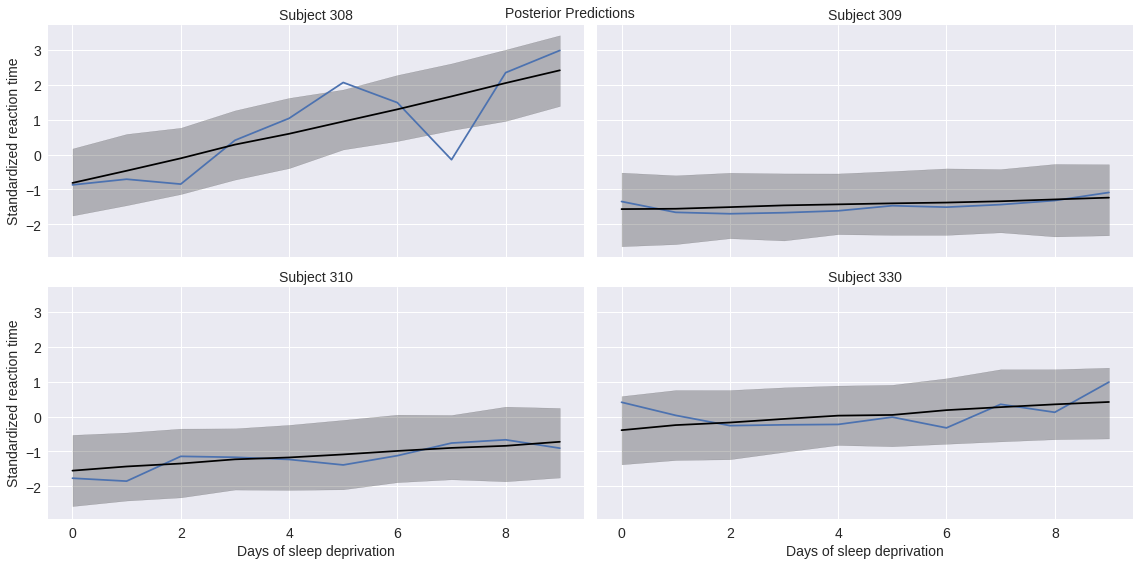

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 8))

for subject_id, ax in zip(subject_map[:4], axes.ravel()):
    pp_subject_plot(pp_df, subject_id, ax)
    ax.set_title("Subject {}".format(subject_id));
    
for ax in axes[-1]:
    ax.set_xlabel("Days of sleep deprivation");
    
for ax in axes[:, 0]:
    ax.set_ylabel("Standardized reaction time");
    
fig.suptitle("Posterior Predictions");
fig.tight_layout();

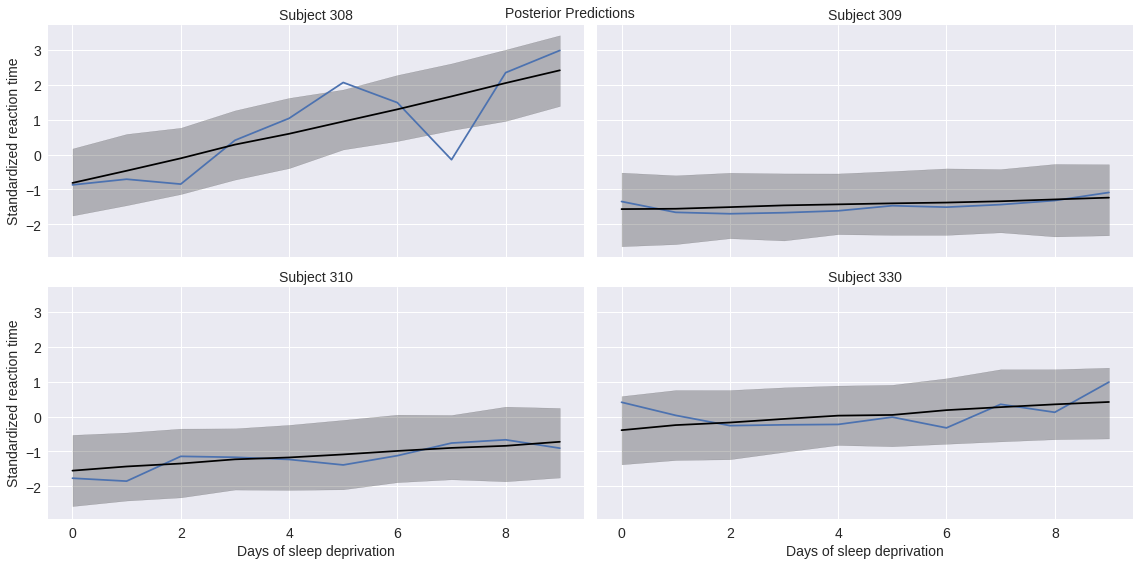

In [46]:
fig

## Hamiltonian Monte Carlo in PyMC3

The following few cells can be ignored, they generate the plot for this slide.

In [47]:
x_ani = np.linspace(0, 1, 100)
y_ani = 1 - 2 * x_ani + np.random.normal(0., 0.25, size=100)

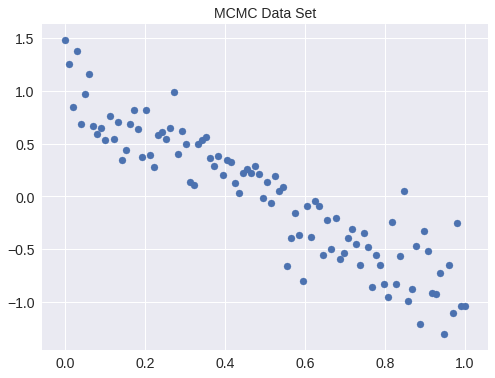

In [48]:
fig, ax = plt.subplots()

ax.scatter(x_ani, y_ani, c=blue);

ax.set_title('MCMC Data Set');

In [49]:
with pm.Model() as mcmc_model:
    β0 = pm.Normal('β0', 0., 10.)
    β = pm.Normal('β', 0., 10.)
    
    σ = pm.HalfCauchy('σ', 5.)
    y_obs = pm.Normal('y_obs', β0 + β * x_ani, σ, observed=y_ani)
    
    mcmc_trace = pm.sample(draws=100, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 94%|█████████▍| 564/600 [00:01<00:00, 506.72it/s]/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
100%|██████████| 600/600 [00:01<00:00, 529.67it/s]


In [50]:
mcmc_cov = np.cov(mcmc_trace['β0'], mcmc_trace['β'])

mcmc_sigma, mcmc_U = np.linalg.eig(mcmc_cov)
mcmc_angle = 180. / np.pi * np.arccos(np.abs(mcmc_U[0, 0]))

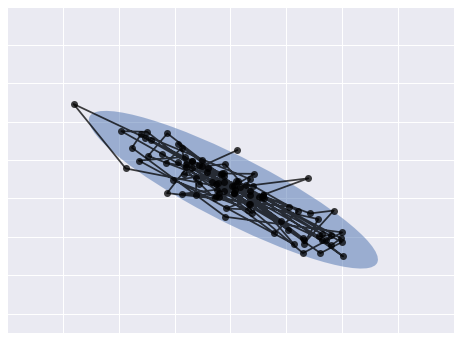

In [51]:
mcmc_fig, mcmc_ax = plt.subplots()

e = Ellipse((mcmc_trace['β0'].mean(), mcmc_trace['β'].mean()),
            2 * np.sqrt(5.991 * mcmc_sigma[0]), 2 * np.sqrt(5.991 * mcmc_sigma[1]),
            angle=mcmc_angle, zorder=5)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(1)

mcmc_ax.plot(mcmc_trace['β0'], mcmc_trace['β'],
             '-o', c='k', alpha=0.75);

mcmc_ax.add_artist(e);

mcmc_ax.set_xticklabels([]);
mcmc_ax.set_xlim(0.8, 1.2);

mcmc_ax.set_yticklabels([]);
mcmc_ax.set_ylim(-2.35, -1.5);

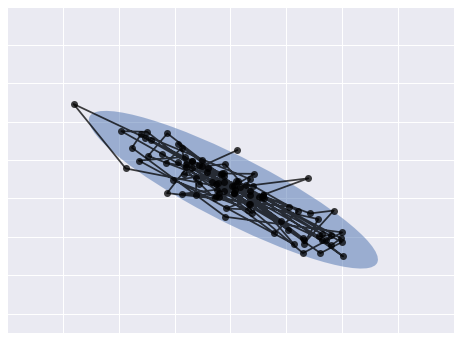

In [52]:
mcmc_fig

### The Curse of Dimensionality

The [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is a well-known concept in machine learning.  It refers to the fact that as the number of dimensions in the sample space increases, samples become (on average) far apart quite quickly.  It is related to the more complicated phenomenon of [concentration of measure](https://en.wikipedia.org/wiki/Concentration_of_measure), which is the actual motivation for Hamiltonian Monte Carlo (HMC) algorithms.

The following plot illustrates one of the one aspect of the curse of dimensionality, that the volume of the unit ball tends to zero as the dimensionality of the space becomes large.  That is, if

$$
\begin{align*}
S_d
    & = \left\{\left.\vec{x} \in \mathbb{R}^d\ \right|\ x_1^2 + \cdots + x_d^2 \leq 1\right\}, \\
\operatorname{Vol}(S_d)
    & = \frac{2 \pi^{\frac{d}{2}}}{d\ \Gamma\left(\frac{d}{2}\right)}.
\end{align*}$$

And we get that $\operatorname{Vol}(S_d) \to 0$ as $d \to \infty$.

In [53]:
def sphere_volume(d):
    return 2. * np.power(np.pi, d / 2.) / d / sp.special.gamma(d / 2)

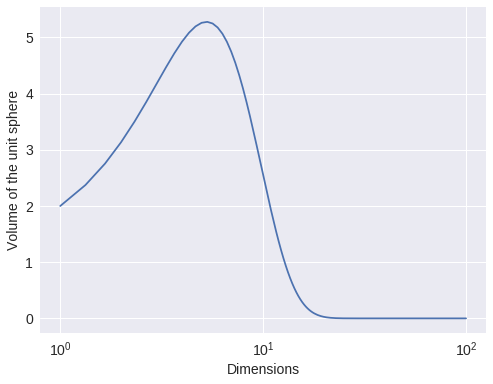

In [54]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, 100, 300)

ax.plot(d_plot, sphere_volume(d_plot));

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_ylabel("Volume of the unit sphere");

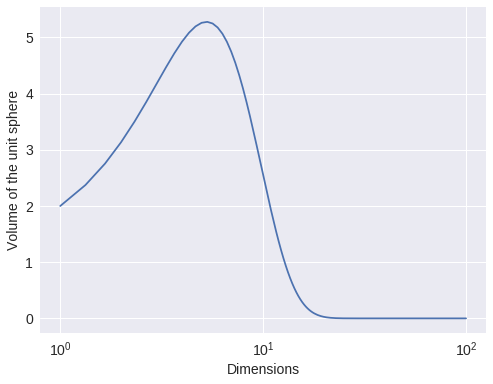

In [55]:
fig

### Hamiltonian Monte Carlo

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/61/Gaussian_curvature.svg" width="500"></center>

HMC algorithms mitigate the problems introduced the the curse of dimensionality/concentration of measure by taking into account the curvature of the posterior distribution.  Its benefits are most apparent in models with many parameters, which correspond to high-dimesional posterior spaces.  For an introduction to HMC algorithms, consult Michael Betancourt's [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434).

The [mathematical quantification of curvature](https://en.wikipedia.org/wiki/Differential_geometry) necessary for HMC algorithms involves differentiating various aspects of the model.  PyMC3 uses Theano for automatic differentiation of tensor expressions to perform HMC sampling.

<center><img src="http://www.deeplearning.net/software/theano/_static/theano_logo.png"></center>

$$\frac{d}{dx} \left(x^3\right) = 3 x^2$$

In [56]:
x = tt.dscalar('x')
x.tag.test_value = 0.

y = x**3

In [57]:
from theano import pprint

pprint(tt.grad(y, x))

'((fill((x ** TensorConstant{3}), TensorConstant{1.0}) * TensorConstant{3}) * (x ** (TensorConstant{3} - TensorConstant{1})))'

### Case Study: 1984 Congressional Votes

To illustrate the benefits of the HMC algorithms that PyMC3 gives easy access to, we use a [data set](https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/) of key 1984 US congressional votes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

In [58]:
%%bash
export DATA_URI='https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

if [[ ! -e /tmp/house-votes-84.data ]]
then
    wget -O /tmp/house-votes-84.data $DATA_URI
fi

In [59]:
N_BILL = 16
BILL_COLS = list(range(N_BILL))


vote_df = (pd.read_csv('/tmp/house-votes-84.data',
                      names=['party'] + BILL_COLS)
            .rename_axis('rep_id', axis=0)
            .reset_index())

In [60]:
vote_df.head()

,rep_id,party,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


**Question:** can we separate Democrats and Republicans based on their voting records?

In [61]:
n_rep, _ = vote_df.shape

We [melt](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) the wide `DataFrame` to a tidy form, which is easier to use for exploration and modeling.

In [62]:
vote_df['party_id'], party_map = vote_df.party.factorize()

long_df = (pd.melt(vote_df, id_vars=['rep_id', 'party_id'], value_vars=BILL_COLS,
                   var_name='bill_id', value_name='vote_raw')
             .assign(bill_id=lambda df: df.bill_id.astype(np.int64),
                     vote=lambda df: np.where(df.vote_raw == 'y', 1,
                                              np.where(df.vote_raw == 'n', 0, np.nan)))
             .dropna()
             .drop('vote_raw', axis=1))

In [63]:
long_df.head()

,rep_id,party_id,bill_id,vote
0,0,0,0,0.0
1,1,0,0,0.0
3,3,1,0,0.0
4,4,1,0,1.0
5,5,1,0,0.0


The following plot shows the proportion of representatives that voted for each bill, broken down by party.  The often large gaps between parties shows that it should be possible to separate Democrats and Republicans based only on their voting records.

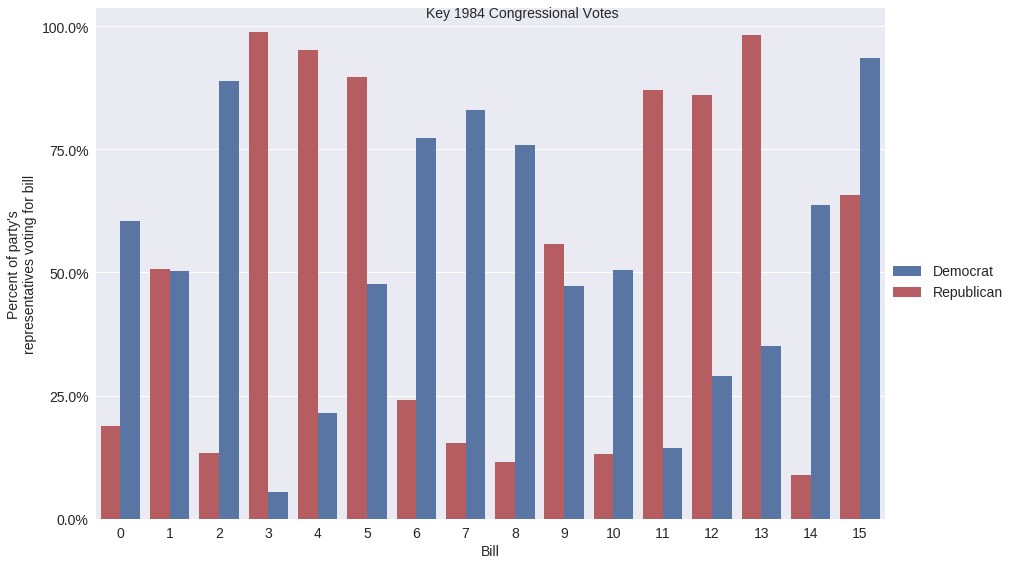

In [64]:
grid = sns.factorplot('bill_id', 'vote', 'party_id', long_df,
                      kind='bar', ci=None, size=8, aspect=1.5, legend=False,
                      palette=[red, blue]);

ax = grid.axes[0, 0]
ax.set_yticks(np.linspace(0, 1, 5));
ax.yaxis.set_major_formatter(pct_formatter);

grid.set_axis_labels('Bill', 'Percent of party\'s\nrepresentatives voting for bill');
grid.add_legend(legend_data={party_map[int(key)].capitalize(): artist
                             for key, artist in grid._legend_data.items()});
grid.fig.suptitle('Key 1984 Congressional Votes');

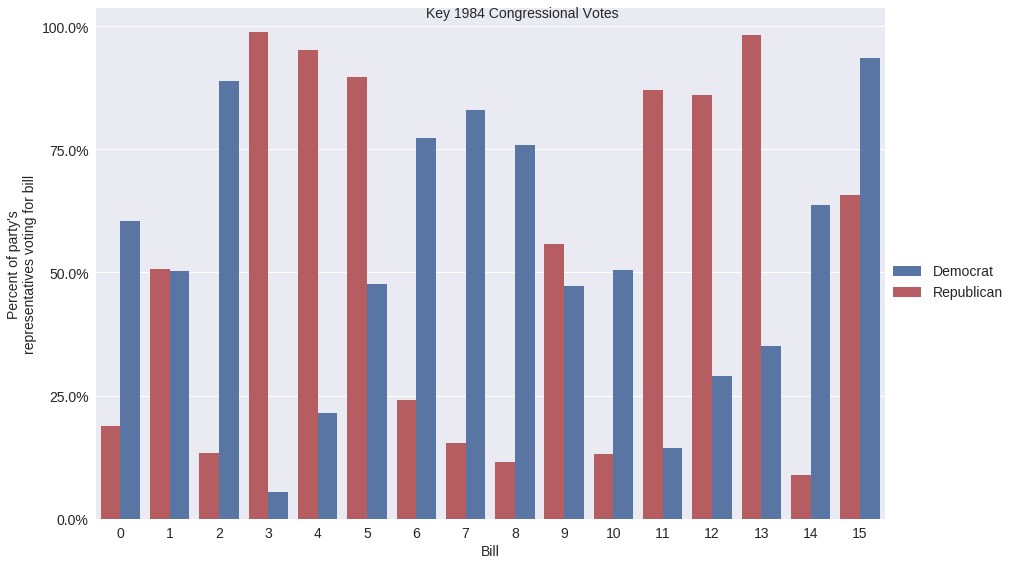

In [65]:
grid.fig

We now build an [ideal point model](https://en.wikipedia.org/wiki/Item_response_theory) of representative's voting patterns.  For more information on Bayesian ideal point models, consult Gelman and Bafumi's [_Practical Issues in Implementing and Understanding Bayesian Ideal Point Estimation_](http://www.stat.columbia.edu/~gelman/research/published/171.pdf).

**Latent State Model**

* Representatives ($\color{blue}{\theta_i}$) and bill ($\color{green}{b_j})$ have _ideal points_ on a liberal-conservative spectrum
    * If the ideal points are equal, there is a 50% chance the representative will vote for the bill

**Optional**

The following `hierarchical_normal` function implements a hierarchical normal prior distribution equivalent to those we used for the varying slopes and intercepts for the sleep deprivation case study.  However, for our high-dimensional ideal point model, a [noncentered parametrization](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) of this prior will lead to more efficient sampling than the naive parametrization we used previously.

In [66]:
def hierarchical_normal(name, shape):
    μ = pm.Normal('μ_{}'.format(name), 0., 1.)
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.Normal('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [67]:
rep_id = long_df.rep_id.values
bill_id = long_df.bill_id.values

vote = long_df.vote.values

In [68]:
with pm.Model() as vote_model:
    # representative ideal points
    θ = pm.Normal('θ', 0., 1., shape=n_rep)
    
    # bill ideal points
    a = hierarchical_normal('a', N_BILL)

The following potential is necessary to [identify](https://en.wikipedia.org/wiki/Identifiability) the model.  It restricts the second representative, a Republican, to have a positive ideal point.  Conventionally in political science, conservativity corresponds to positive ideal points.  See the Gelman and Bafumi paper referenced above for a discussion of why this restriction is necessary.

In [69]:
with vote_model:
    θ_pot = pm.Potential('θ_pot', tt.switch(θ[1] < 0., -np.inf, 0.))

* Bills also have an ability to _discriminate_ ($\color{red}{a_j}$) between conservative and liberal representatives
    * Some bills have broad bipartisan support, while some provoke votes along party lines

In [70]:
with vote_model:
    # bill discrimination parameters
    b = hierarchical_normal('b', N_BILL)

This model has

In [71]:
n_rep + 2 * (N_BILL + 1)

469

parameters

This model is a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) with latent parameters.

**Observation Model**

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\left(\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)\right)}
\end{align*}
$$

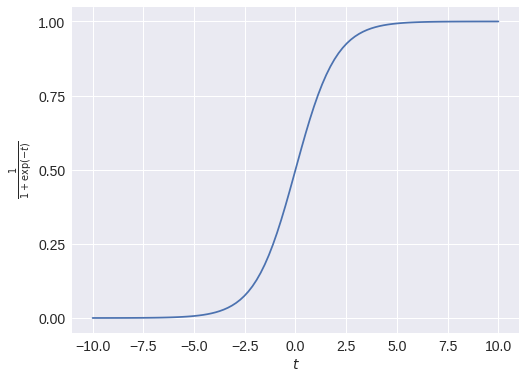

In [72]:
fig, ax = plt.subplots()

t_plot = np.linspace(-10, 10, 100)
ax.plot(t_plot, sp.special.expit(t_plot));

ax.set_xlabel("$t$");

ax.set_yticks(np.linspace(0, 1, 5));
ax.set_ylabel(r"$\frac{1}{1 + \exp(-t)}$");

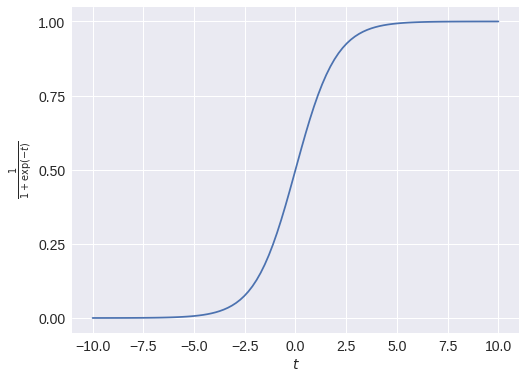

In [73]:
fig

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\left(\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)\right)}
\end{align*}
$$

In [74]:
with vote_model:
    η = a[bill_id] * θ[rep_id] - b[bill_id]
    p = pm.math.sigmoid(η)
    
    obs = pm.Bernoulli('obs', p, observed=vote)

**Hamiltonian Monte Carlo Inference**

In [75]:
with vote_model:
    nuts_trace = pm.sample(init='adapt_diag', njobs=N_JOBS,
                           random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
100%|██████████| 1000/1000 [02:06<00:00, 10.38it/s]


### Convergence Diagnostics

We see that the chains appear to have converged well.

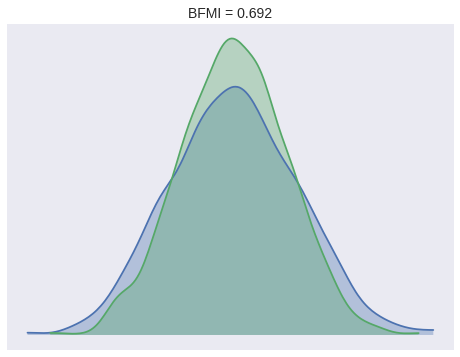

In [76]:
ax = pm.energyplot(nuts_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(nuts_trace)));

In [77]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(nuts_trace).values())

1.0135857288309107

### Ideal Points

The model has effectively separated Democrats from Republicans, soley based on their voting records.

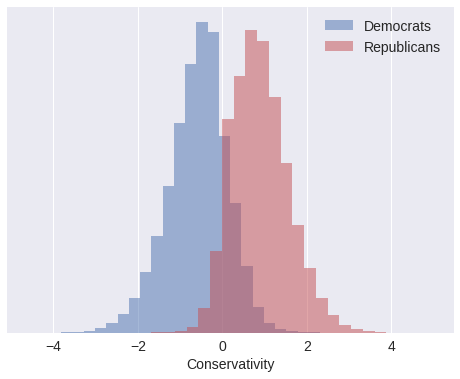

In [78]:
fig, ax = plt.subplots()

dem_ids = vote_df[vote_df.party == 'democrat'].rep_id.values
rep_ids = vote_df[vote_df.party == 'republican'].rep_id.values

ax.hist(nuts_trace['θ'][:, dem_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        color=blue, label='Democrats');
ax.hist(nuts_trace['θ'][:, rep_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        color=red, label='Republicans');

ax.set_xlabel("Conservativity");

ax.set_yticks([]);

ax.legend();

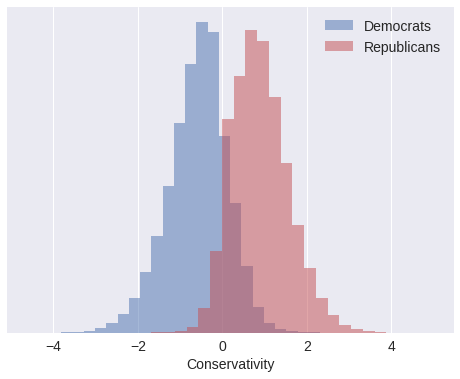

In [79]:
fig

### Discriminative Ability of Bills

The following plot shows that it was important to include the discrimination parameters `a`, as some bills are quantifiably more useful for separating Democrats from Republicans.

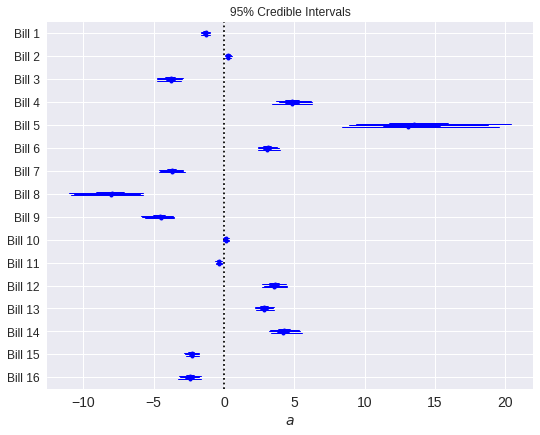

In [80]:
pm.forestplot(nuts_trace, varnames=['a'], rhat=False, xtitle="$a$",
              ylabels=["Bill {}".format(i + 1) for i in range(N_BILL)]);

### Comparison to Non-Hamiltonian MCMC

We now use standard MCMC methods (in this case, the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm) on this model to illustrate the power of HMC algorithms.

In [81]:
with vote_model:
    step = pm.Metropolis()
    met_trace_ = pm.sample(10000, step, njobs=N_JOBS, random_seed=JOB_SEEDS)
    
met_trace = met_trace_[5000::5]

100%|██████████| 10500/10500 [10:20<00:00, 16.94it/s]  


We see that the standard MCMC samples are quite far from converging, as their Gelman-Rubin statistics vastly exceed one.

In [82]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(met_trace).values())

39.87901257961822

The following plot shows the vast difference between the standard MCMC and HMC samples, and the low quality of the standard MCMC samples.

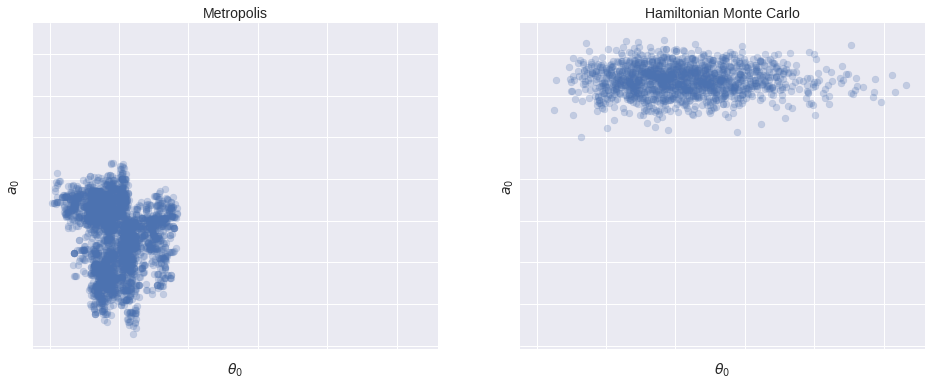

In [83]:
fig, (met_ax, nuts_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

met_ax.scatter(met_trace['θ'][:, 0], met_trace['a'][:, 0],
               alpha=0.25);

met_ax.set_xticklabels([]);
met_ax.set_xlabel(r"$θ_0$");

met_ax.set_yticklabels([]);
met_ax.set_ylabel("$a_0$");

met_ax.set_title("Metropolis");

nuts_ax.scatter(nuts_trace['θ'][:, 0], nuts_trace['a'][:, 0],
                alpha=0.25);

nuts_ax.set_xlabel(r"$θ_0$");
nuts_ax.set_ylabel("$a_0$");
nuts_ax.set_title("Hamiltonian Monte Carlo");

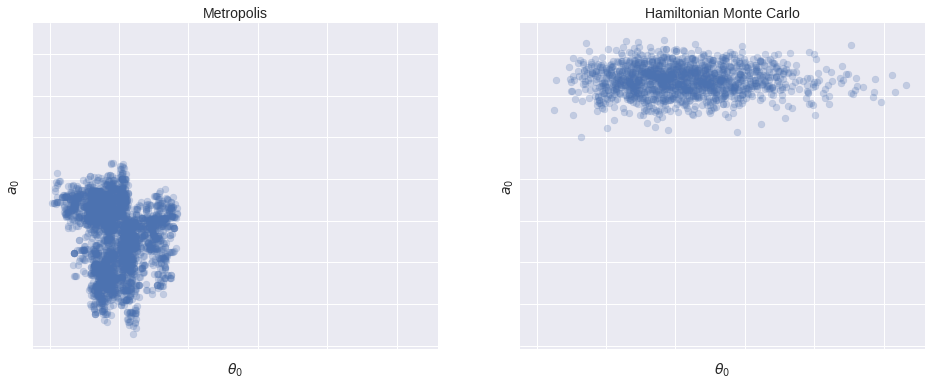

In [84]:
fig

## Next Steps

The following books/GitHub repositories provide good introductions to PyMC3 and Bayesian statistics.

### PyMC3

<table>
    <tr>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
        <td>
            <a href="https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python"><img src="https://d255esdrn735hr.cloudfront.net/sites/default/files/imagecache/ppv4_main_book_cover/3804OS_4958_Bayesian%20Analysis%20with%20Python.jpg"></a>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
    </tr>
</table>

The following chart gives an overview of the larger probabilistic programming ecosystem.

## Probabilistic Programming Ecosystem

<table>
    <tr>
        <th>Probabilistic Programming System</th>
        <th>Language</th>
        <th>License</th>
        <th>Discrete Variable Support</th>
        <th>Automatic Differentiation/Hamiltonian Monte Carlo</th>
        <th>Variational Inference</th>
    </tr>
    <tr>
        <td><a href='http://pymc-devs.github.io/pymc3/'>PyMC3</a></td>
        <td>Python</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://mc-stan.org/'>Stan</a></td>
        <td>C++, R, Python, ...</td>
        <td>BSD 3-clause</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href="http://edwardlib.org/">Edward</a></td>
        <td>Python, ...</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://www.mrc-bsu.cam.ac.uk/software/bugs/'>BUGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
    <tr>
        <td><a href='chrome-extension://ojhmphdkpgbibohbnpbfiefkgieacjmh/app/index.html'>JAGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

## Thank you!

<img src="https://media1.giphy.com/media/xIJLgO6rizUJi/giphy.gif">

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [austin.rochford@gmail.com](mailto:austin.rochford@gmail.com) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)


The Jupyter notebook used to generate these slides is available [here](https://gist.github.com/AustinRochford/d83ecc6acd17a632a2b9df788386540b).

In [85]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=os-bayes-pymc3-fosscon-2017 \
    ./Open\ Source\ Bayesian\ Inference\ in\ Python\ with\ PyMC3.ipynb

[NbConvertApp] Converting notebook ./Open Source Bayesian Inference in Python with PyMC3.ipynb to slides
[NbConvertApp] Writing 1423565 bytes to ./os-bayes-pymc3-fosscon-2017.slides.html
